In [1]:
import pandas as pd
import janitor
from utilities import calculate_summary_statistics, pandas_to_tex, save_mpl_fig

import warnings

warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm

sns.set_theme(context="notebook", font_scale=1.35, style="whitegrid", palette="dark")

df = pd.read_csv("../data/ind_data.csv")
df.head(3)

,caseid,duration,visits,duration_min,duration_hr,harmless,malicious,suspicious,undetected,timeout,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,47541,263115,17194,4385,73,37198,19,5,11033,0,...,2,2,6,2,12,3,Female,White,HS or Below,65+
1,56565,187793,11479,3129,52,22541,10,3,6576,0,...,3,3,5,2,17,2,Female,White,Some college,65+
2,203271,94510,6540,1575,26,10298,8,2,2943,0,...,6,1,2,-1,54,3,Female,White,Postgrad,35-49


In [2]:
df["caseid"].nunique()

1134

In [3]:
# How many exposured at least once to malicious
100 * (df.query("malicious_visits>0").shape[0]) / len(df)

51.32275132275132

## Exposure

In [4]:
rel_cols = ["malicious_bool", "malicious_visits", "malicious_min", "suspicious_bool"]
percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
df_summ = (
    df[rel_cols]
    .describe(percentiles=[p / 100 for p in percentiles])
    .astype(int)
    .T.drop(columns="count")
    .applymap(lambda x: f"{x:,}")
    .reset_index(names="var")
    .assign(
        var=lambda df: df["var"].replace(
            {
                "malicious_bool": "\# unique malicious sites",
                "malicious_visits": "\# visits to malicious sites",
                "malicious_min": "\# minutes spent on malicious sites",
                "suspicious_bool": "\# unique suspicious sites",
            }
        )
    )
)
pandas_to_tex(df_summ, "../tabs/summ_exposure")
df_summ

,var,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
0,\# unique malicious sites,1,4,0,0,0,0,1,2,5,8,16,80
1,\# visits to malicious sites,20,136,0,0,0,0,1,9,33,73,264,"4,006"
2,\# minutes spent on malicious sites,13,114,0,0,0,0,0,2,12,37,205,"2,879"
3,\# unique suspicious sites,2,4,0,0,0,0,2,4,7,10,18,58


### Skew

In [5]:
_percentiles = [round(x, 2) for x in np.arange(0.0, 1.05, 0.05)]

df_normalized = (
    df[rel_cols]
    .quantile(_percentiles)
    .reset_index(names="percentile")
    .assign(percentile=lambda df_: 100 * df_["percentile"])
    .set_index("percentile")
    .apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    #     .iloc[:-1]
)

df_normalized

,malicious_bool,malicious_visits,malicious_min,suspicious_bool
percentile,,,,
0.0,0.0000,0.000000,0.000000,0.000000
5.0,0.0000,0.000000,0.000000,0.000000
10.0,0.0000,0.000000,0.000000,0.000000
15.0,0.0000,0.000000,0.000000,0.000000
20.0,0.0000,0.000000,0.000000,0.000000
25.0,0.0000,0.000000,0.000000,0.000000
30.0,0.0000,0.000000,0.000000,0.017241
35.0,0.0000,0.000000,0.000000,0.017241
40.0,0.0000,0.000000,0.000000,0.017241


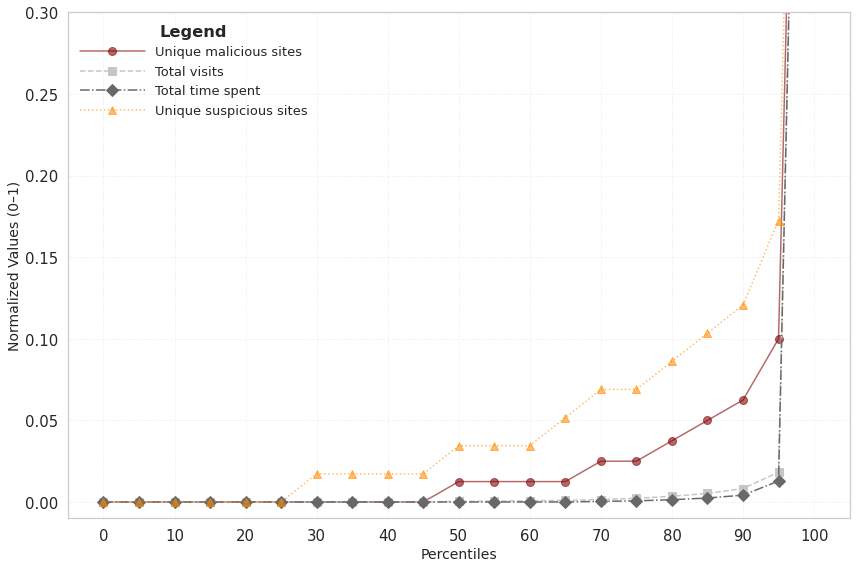

In [6]:
# Plot
# ----------------------------------
legend_labels = [
    "Unique malicious sites",
    "Total visits",
    "Total time spent",
    "Unique suspicious sites",
]

# Define specific colors for the first and last lines, with grayscale for the rest
colors = (
    ["#80000095"]
    + sns.color_palette("Greys", len(df_normalized.columns) - 2)
    + ["#FF8C0095"]
)
# "#800000" is a maroon shade, "#FF8C00" is a dark orange shade

# Define markers and line styles
markers = ["o", "s", "D", "^"]
linestyles = ["-", "--", "-.", ":"]

# ----------------------------------
# Plot
_scale = 1
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

for i, (column, label) in enumerate(zip(df_normalized.columns, legend_labels)):
    plt.plot(
        df_normalized.index,
        df_normalized[column],
        marker=markers[i % len(markers)],  # Cycle through markers
        color=colors[i],  # Use custom colors
        linestyle=linestyles[i % len(linestyles)],  # Cycle through line styles
        label=label,  # Custom label
        markersize=8,  # Adjust marker size
        #         alpha=0.8                                     # Adjust transparency (0.8 for slight transparency)
    )

# plt.title("Normalized Percentiles of Different Variables", fontsize=16)
plt.xlabel("Percentiles", fontsize=14)
plt.ylabel("Normalized Values (0\u20131)", fontsize=14)
plt.xticks(np.arange(0, 110, 10))
plt.ylim(-0.01, 0.3)

# ----------------------------------
# Legend
plt.legend(
    title="Legend",
    loc="upper left",
    fontsize=13,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=5,  # Increase line length in legend
)

plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/skewness-comparison-minmax")

## Exposure by demo

### Tabulate

In [7]:
percentiles = [5, 10, 25, 50, 75, 90, 95]

In [8]:
gender_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="gender_lab",
    value_column="malicious_bool",
    percentiles=percentiles,
)
pandas_to_tex(gender_mal_bool_summ, "../tabs/gender_mal_bool_summ")
gender_mal_bool_summ

,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,Female,595 (52.5\%),1.6,4.3,0,0.0,0.0,0.0,0.0,2.0,4.0,6.3,67
1,Male,539 (47.5\%),2.3,5.0,0,0.0,0.0,0.0,1.0,3.0,6.2,10.0,80


In [9]:
race_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="race_lab",
    value_column="malicious_bool",
    percentiles=percentiles,
)
pandas_to_tex(race_mal_bool_summ, "../tabs/race_mal_bool_summ")
race_mal_bool_summ

,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,White,720 (63.5\%),1.8,3.8,0,0.0,0.0,0.0,0.0,2.0,5.0,7.0,67
1,Hispanic,168 (14.8\%),1.9,3.6,0,0.0,0.0,0.0,0.0,2.0,5.3,10.3,23
2,Black,144 (12.7\%),3.2,8.8,0,0.0,0.0,0.0,1.0,3.0,7.7,12.8,80
3,Other,56 (4.9\%),1.5,2.8,0,0.0,0.0,0.0,1.0,2.0,4.0,5.0,16
4,Asian,46 (4.1\%),1.5,2.6,0,0.0,0.0,0.0,0.0,2.0,4.5,6.8,12


In [10]:
educ_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="educ_lab",
    value_column="malicious_bool",
    percentiles=percentiles,
)
pandas_to_tex(educ_mal_bool_summ, "../tabs/educ_mal_bool_summ")
educ_mal_bool_summ

,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,HS or Below,411 (36.2\%),2.3,5.5,0,0.0,0.0,0.0,1.0,2.0,5.0,9.0,67
1,Some college,326 (28.7\%),2.1,5.4,0,0.0,0.0,0.0,0.0,2.0,5.0,9.8,80
2,College,255 (22.5\%),1.5,2.7,0,0.0,0.0,0.0,1.0,2.0,4.0,6.0,18
3,Postgrad,142 (12.5\%),1.4,2.5,0,0.0,0.0,0.0,0.0,1.0,4.0,7.0,12


In [11]:
category_names = {
    "<25": "$<$ 25",
    "25-34": "25--34",
    "35-49": "35--49",
    "50-64": "50--64",
    "65+": "$>$ 65",
}
agegroup_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="agegroup_lab",
    value_column="malicious_bool",
    percentiles=percentiles,
    sort_order="custom",
#     custom_order=["<25", "25--34", "35--49", "50--64", "65+"],
    custom_order=category_names.keys(),
    category_names=category_names,
)
pandas_to_tex(agegroup_mal_bool_summ, "../tabs/agegroup_mal_bool_summ")
agegroup_mal_bool_summ

,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,$<$ 25,93 (8.2\%),2.9,8.7,0,0.0,0.0,0.0,1.0,3.0,7.0,10.8,80
1,25--34,200 (17.6\%),1.9,3.6,0,0.0,0.0,0.0,0.5,2.0,5.0,9.0,23
2,35--49,285 (25.1\%),1.4,2.5,0,0.0,0.0,0.0,0.0,2.0,4.0,7.0,15
3,50--64,288 (25.4\%),2.4,6.2,0,0.0,0.0,0.0,1.0,2.0,6.0,10.0,67
4,$>$ 65,268 (23.6\%),1.7,2.9,0,0.0,0.0,0.0,1.0,2.0,5.0,7.0,24


### eCDF

In [12]:
df['malicious_bool'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    1134.000000
mean        1.928571
std         4.670541
min         0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         1.000000
60%         1.000000
70%         2.000000
80%         3.000000
90%         5.000000
95%         8.000000
96%         9.000000
97%        11.000000
98%        13.000000
99%        16.000000
max        80.000000
Name: malicious_bool, dtype: float64

In [13]:
line_styles = ["-", "--", "-.", ":"]  # Different line styles for distinct appearance
# colors = ["#0B1B32", "#83A6CE", "#0D1E4C", "#C48CB3", "#E5C9D7", "#26415E"]
colors = ["#88CCEE", "#CC6677", "#4477AA", "#DDCC77", "#117733", "#AA4499"]

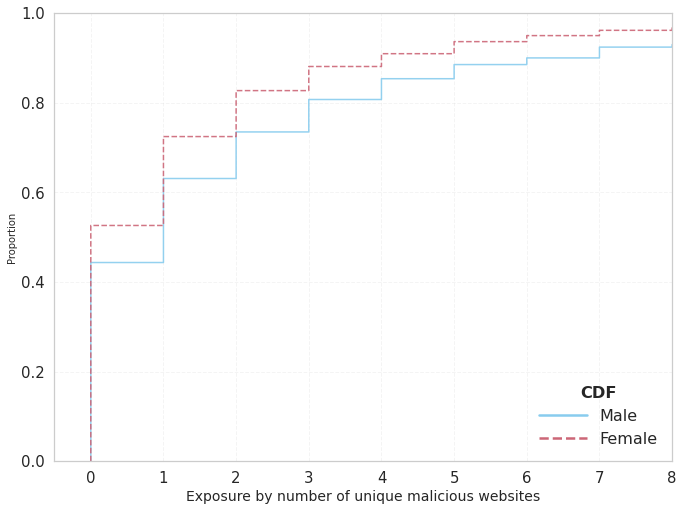

In [14]:
# Gender
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.ecdfplot(data=df, x="malicious_bool", hue="gender_lab", alpha=.9, ax=ax)

# =================================================
# Modify lines
unique_groups = df['gender_lab'].unique()[::-1]
for i, (line, group) in enumerate(zip(ax.get_lines(), unique_groups)):
    line.set_color(colors[i])
    line.set_linestyle(line_styles[i % len(line_styles)])
    line.set_linewidth(1.5)

    
# =================================================
# Legend
legend_handles = [
    Line2D([0], [0], color=colors[i], lw=2.5, linestyle=line_styles[i % len(line_styles)], label=group) 
    for i, group in enumerate(unique_groups)
]

plt.legend(
    handles=legend_handles,  # Pass custom handles here
    title="CDF",
    loc="lower right",
    fontsize=16,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=3,  # Increase line length in legend
)

# =================================================
plt.xlabel("Exposure by number of unique malicious websites", fontsize=14)
ax.set_xlim(-0.5, 8)
plt.xticks(np.arange(0, 9, 1))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/cdf-unique-malicious-gender")

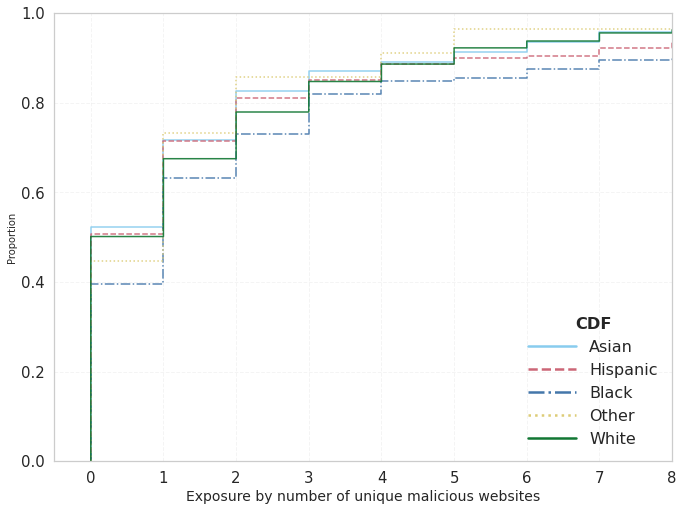

In [15]:
# Race
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.ecdfplot(data=df, x="malicious_bool", hue="race_lab", alpha=.9, ax=ax)

# =================================================
# Modify lines
unique_groups = df['race_lab'].unique()[::-1]
for i, (line, group) in enumerate(zip(ax.get_lines(), unique_groups)):
    line.set_color(colors[i])
    line.set_linestyle(line_styles[i % len(line_styles)])
    line.set_linewidth(1.5)

    
# =================================================
# Legend
legend_handles = [
    Line2D([0], [0], color=colors[i], lw=2.5, linestyle=line_styles[i % len(line_styles)], label=group) 
    for i, group in enumerate(unique_groups)
]

plt.legend(
    handles=legend_handles,  # Pass custom handles here
    title="CDF",
    loc="lower right",
    fontsize=16,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=3,  # Increase line length in legend
)

# =================================================
plt.xlabel("Exposure by number of unique malicious websites", fontsize=14)
ax.set_xlim(-0.5, 8)
plt.xticks(np.arange(0, 9, 1))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/cdf-unique-malicious-race")

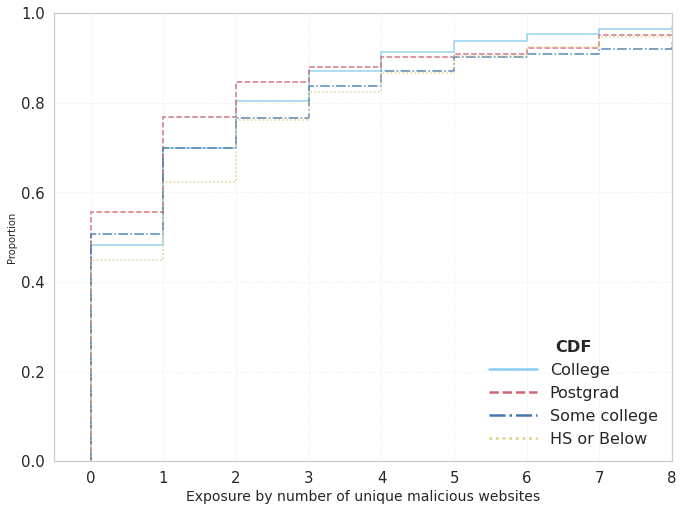

In [16]:
# Education
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.ecdfplot(data=df, x="malicious_bool", hue="educ_lab", alpha=.9, ax=ax)

# =================================================
# Modify lines
unique_groups = df['educ_lab'].unique()[::-1]
for i, (line, group) in enumerate(zip(ax.get_lines(), unique_groups)):
    line.set_color(colors[i])
    line.set_linestyle(line_styles[i % len(line_styles)])
    line.set_linewidth(1.5)

    
# =================================================
# Legend
legend_handles = [
    Line2D([0], [0], color=colors[i], lw=2.5, linestyle=line_styles[i % len(line_styles)], label=group) 
    for i, group in enumerate(unique_groups)
]

plt.legend(
    handles=legend_handles,  # Pass custom handles here
    title="CDF",
    loc="lower right",
    fontsize=16,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=3,  # Increase line length in legend
)

# =================================================
plt.xlabel("Exposure by number of unique malicious websites", fontsize=14)
ax.set_xlim(-0.5, 8)
plt.xticks(np.arange(0, 9, 1))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/cdf-unique-malicious-education")

## Plot age

In [17]:
bins = [1930, 1958, 1973, 1988, 1998, 2003]
labels = ["65+", "50-64", "35-49", "25-34", "< 25"]

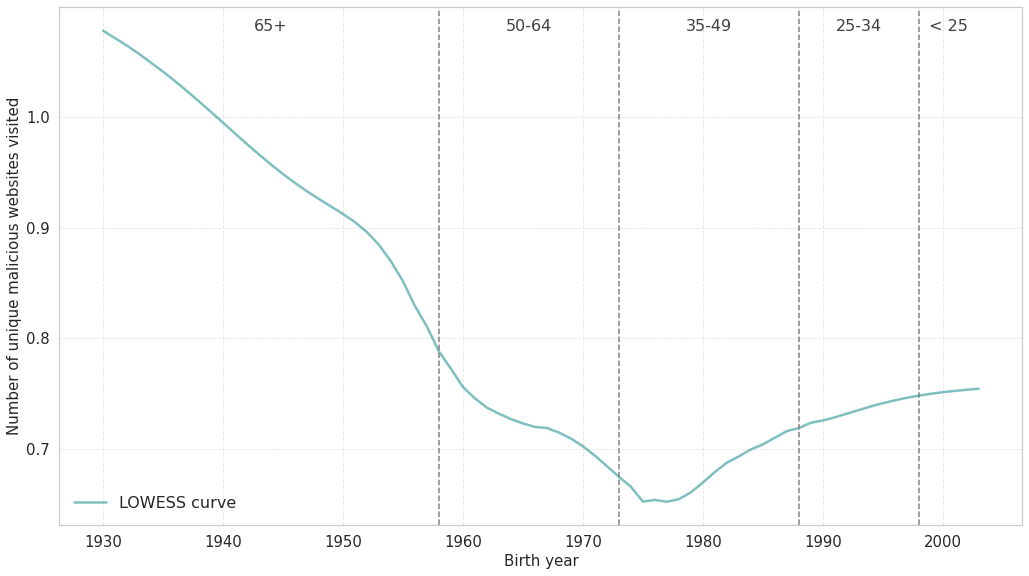

In [18]:
_scale = 0.9
_aspect_ratio = (16, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

lowess = sm.nonparametric.lowess(
    df["malicious_bool"],
    df["birthyr"],
    frac=0.5,
)

plt.plot(
    lowess[:, 0], lowess[:, 1], color="teal", lw=2.5, alpha=0.5, label="LOWESS curve"
)

plt.legend(frameon=False, loc="lower left", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel("Birth year", size=15)
plt.ylabel("Number of unique malicious websites visited", size=15)
plt.tight_layout()
plt.locator_params(axis="y", nbins=8)
save_mpl_fig("../figs/lowess-unique-mal-birthyr")

for i in range(len(bins) - 1):
    mid_point = (bins[i] + bins[i + 1]) / 2
    plt.text(
        mid_point,
        max(lowess[:, 1]) * 1,
        f"{labels[i]}",
        ha="center",
        fontsize=16,
        color=".25",
    )

# Add vertical lines for each inner boundary
for birth_year in bins[1:-1]:
    plt.axvline(x=birth_year, color="grey", linestyle="--", lw=1.5)

save_mpl_fig("../figs/lowess-unique-mal-birthyr-annotated")

### Winsorized

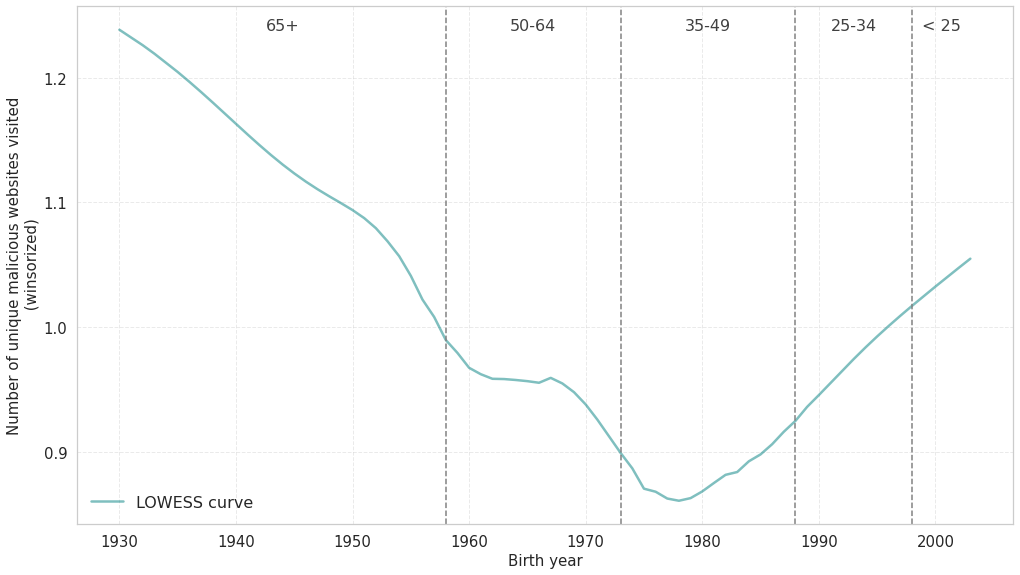

In [19]:
_scale = 0.9
_aspect_ratio = (16, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

winsorized_mal_bool = winsorize(df["malicious_bool"], limits=(0.0, 0.2))

lowess = sm.nonparametric.lowess(winsorized_mal_bool, df["birthyr"], frac=0.5)

plt.plot(
    lowess[:, 0], lowess[:, 1], color="teal", lw=2.5, alpha=0.5, label="LOWESS curve"
)

plt.legend(frameon=False, loc="lower left", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel("Birth year", size=15)
plt.ylabel("Number of unique malicious websites visited\n (winsorized)", size=15)
plt.tight_layout()
plt.locator_params(axis="y", nbins=8)
save_mpl_fig("../figs/lowess-unique-mal-birthyr-winsorized")


for i in range(len(bins) - 1):
    mid_point = (bins[i] + bins[i + 1]) / 2
    plt.text(
        mid_point,
        max(lowess[:, 1]) * 1,
        f"{labels[i]}",
        ha="center",
        fontsize=16,
        color=".25",
    )

# Add vertical lines for each inner boundary
for birth_year in bins[1:-1]:
    plt.axvline(x=birth_year, color="grey", linestyle="--", lw=1.5)

save_mpl_fig("../figs/lowess-unique-mal-birthyr-winsorized-annotated")